In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
class Double_Gridworld:
    def __init__(self, num_rows=5, num_cols=5, ape_start_pos="random", button_pos=np.array([[2, 4], [2, 4]]),
                good_food_pos=np.array([[2, 0], [2,0]]), bad_food_pos="random",
                good_food_reward=15, bad_food_reward=5, screech_reward=-2):
        """Environment for this experiment, two separate gridworlds for the two monkeys
            Note: In the current setup, multiple things can be on one grid cell."""
        # General variables
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.good_food_reward = good_food_reward
        self.bad_food_reward = bad_food_reward
        self.screech_reward = screech_reward
        
        # Initialise variables
        self.ape_screeched = np.array([False,False])
        
        # Set agent start positions
        if ape_start_pos == "random":
            self.ape_pos = np.array([self._generate_random_position() for i in range(2)])
        else:
            self.ape_pos = ape_start_pos
        
        # Set button positions
        if button_pos == "random":
            self.button_pos = np.array([self._generate_random_position() for i in range(2)])
        else:
            self.button_pos = button_pos
        
        # Set initial good food position
        if good_food_pos == "random":
            self.drop_good_food_randomly = True
            self.good_food_pos = np.array([[-1,-1] for i in range(2)]) # Good food is not dropped until the buttons are pressed simultaneously
        else:
            self.drop_good_food_randomly = False
            self.good_food_drop = good_food_pos
            self.good_food_pos = np.array([[-1,-1] for i in range(2)]) # Good food is not dropped until the buttons are pressed simultaneously
        self.good_food_active = [False, False]
        
        # Set initial bad food positions
        if bad_food_pos == "random":
            self.drop_bad_food_randomly = True
            self.bad_food_pos = np.array([self._generate_random_position() for i in range(2)])
        else:
            self.drop_bad_food_randomly = False
            self.bad_food_drop = bad_food_pos
            self.bad_food_pos = self.bad_food_drop
        self.bad_food_active = [True, True]
        
        return None
    
    def _generate_random_position(self):
        """Return a position value that exists within a Gridworld"""
        row = np.random.randint(self.num_rows)
        col = np.random.randint(self.num_cols)
        return np.array([row, col])
    
    def drop_food(self, which_grid, food_type):
        """Drop a type of food somewhere on a grid"""
        print(food_type, "food dropped")
        if food_type == "good":
            self.good_food_active[which_grid] = True
            if self.drop_good_food_randomly:
                self.good_food_pos[which_grid] = self._generate_random_position()
            else:
                self.good_food_pos[which_grid] = self.good_food_drop[which_grid]
        elif food_type == "bad":
            self.bad_food_active[which_grid] = True
            if self.drop_bad_food_randomly:
                self.bad_food_pos[which_grid] = self._generate_random_position()
            else:
                self.bad_food_pos[which_grid] = self.bad_food_drop[which_grid]
        else:
            raise ValueError("Value for food_type not recognised: "+str(food_type))
        
        return None
    
    def food_eaten(self, which_grid, food_type):
        """Remove a type of food from a grid when an Ape eats it"""
        print(food_type, "food eaten")
        if food_type == "good":
            self.good_food_active[which_grid] = False
            self.good_food_pos[which_grid] = np.array([-1,-1]) # Placeholder position
        elif food_type == "bad":
            self.bad_food_active[which_grid] = False
            self.bad_food_pos[which_grid] = np.array([-1,-1]) # Placeholder position
        else:
            raise ValueError("Value for food_type not recognised: "+str(food_type))
        
        return None
    
    def move_ape(self, which_grid, direction):
        """Move one of the apes within its Gridworld"""
        # Initialise reward
        r = -1 # Apes will always receive a -1 each move to incentivise direct routes
        
        # Take into account whether the other ape screeched
        if self.ape_screeched[which_grid-1]:
            r += self.screech_reward
        self.ape_screeched[which_grid-1] = False
        
        # Change the position of the ape
        if direction == "u":
            self.ape_pos[which_grid] = self.ape_pos[which_grid] + np.array([0, 1])
        elif direction == "d":
            self.ape_pos[which_grid] = self.ape_pos[which_grid] + np.array([0, -1])
        elif direction == "l":
            self.ape_pos[which_grid] = self.ape_pos[which_grid] + np.array([-1, 0])
        elif direction == "r":
            self.ape_pos[which_grid] = self.ape_pos[which_grid] + np.array([1, 0])
        elif direction == "s":
            # The ape is standing still and screeching
            self.ape_screeched[which_grid] = True
        else:
            raise ValueError("Direction not recognised: "+str(direction))
        
        # Check whether the ape is on the same cell as anything else
        #   The buttons
        if np.array_equal(self.ape_pos[which_grid], self.button_pos[which_grid]):
            if np.array_equal(self.ape_pos[which_grid-1], self.button_pos[which_grid-1]):
                # If both apes are on their buttons, drop the good food
                for f in range(2): #Good food morsels for each Gridworld
                    if not self.good_food_active[f]:
                        self.drop_food(f, "good")
        
        #   The good food
        if np.array_equal(self.ape_pos[which_grid], self.good_food_pos[which_grid]):
            # The ape found the good food! Let them eat it but don't drop more
            self.food_eaten(which_grid, "good")
            r += self.good_food_reward
        
        #   The bad food
        if np.array_equal(self.ape_pos[which_grid], self.bad_food_pos[which_grid]):
            # The ape found the bad food! Let them eat it and drop more
            self.food_eaten(which_grid, "bad")
            r += self.bad_food_reward
            self.drop_food(which_grid, "bad")
        
        return r
    
    ###################
    ## Visualisation ##
    ###################
    def pos_to_image_extent(self, pos):
        x = pos[0]
        y = pos[1]
        return [x, x+1, y, y+1]
    
    def visualise(self):
        # Initialise the figure as two graphs, each containing one grid
        fig, (grid0, grid1) = plt.subplots(figsize=(20,10), ncols=2, nrows=1, gridspec_kw={"width_ratios":[1,1]})
        
        both_grids = np.array([grid0, grid1])
        for g in range(len(both_grids)):
            both_grids[g].set_xlim((0, self.num_cols))
            both_grids[g].set_ylim((0, self.num_rows))
            both_grids[g].tick_params(length=0, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            plt.grid()
            
#             # Add button
#             image_extent = self.pos_to_image_extent(self.button_pos[g])
#             both_grids[g].imshow(plt.imread("./button_image.png"), extent=image_extent)

            # Add bad food (apple slice)
            if self.bad_food_active[g]:
                image_extent = self.pos_to_image_extent(self.bad_food_pos[g])
                both_grids[g].imshow(plt.imread("./apple_image.png"), extent=image_extent)

            # Add good food (banana)
            if self.good_food_active[g]:
                image_extent = self.pos_to_image_extent(self.good_food_pos[g])
                both_grids[g].imshow(plt.imread("./banana_image.png"), extent=image_extent)

            # Add agent (ape)
            image_extent = self.pos_to_image_extent(self.ape_pos[g])
            both_grids[g].imshow(plt.imread("./ape_image.jpg"), extent=image_extent)
            
        plt.show()
        return None

In [42]:
class Ape:
    def __init__(self, env, which_grid, eps=0.1, alpha=0.2, gamma=0.9):
        """Monkey class designed to explore one of the gridworlds
        Learns using Q-learning"""
        self.env = env
        self.which_grid = which_grid
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        
        self.possible_moves = ["u", "r", "d", "l", "s"] #up, down, left, right, screech
        # a for each move, s is four sets of 2D distances with values between -4 and 4 (inclusive)
        self.Q = np.zeros([len(self.possible_moves)]+8*[9])
        self.state = self.get_state()
        
        return None
    
    def get_state(self):
        """Retrieve information from the environment to help with learning
        Returns information as a list of indices to access Q"""
        ape_pos = self.env.ape_pos[self.which_grid]
        button_pos = self.env.button_pos[self.which_grid]
        good_food_pos = self.env.good_food_pos[self.which_grid]
        bad_food_pos = self.env.bad_food_pos[self.which_grid]
        
        other_ape_pos = self.env.ape_pos[self.which_grid-1]
        other_button_pos = self.env.button_pos[self.which_grid-1]
        
        button_dist = list(self._get_distance(pos0=ape_pos, pos1=button_pos))
        good_food_dist = list(self._get_distance(pos0=ape_pos, pos1=good_food_pos))
        bad_food_dist = list(self._get_distance(pos0=ape_pos, pos1=bad_food_pos))
        other_button_dist = list(self._get_distance(pos0=other_ape_pos, pos1=other_button_pos))
        
        return button_dist + good_food_dist + bad_food_dist + other_button_dist
    
    def _get_distance(self, pos0, pos1):
        """Get the distance between two points on the same Gridworld"""
        if np.array_equal(pos1, np.array([-1,-1])):
            # The object at pos1 is not active
            return np.array([0,0])
        else:
            return pos1-pos0
        
    def choose_move(self):
        """Decide on the next move based on Q and an epsilon-greedy algorithm"""
        if np.random.rand() < self.eps:
            # Exploit current knowledge
            move_index = np.argmax(self.Q[:, self.state[0], self.state[1], self.state[2], self.state[3], self.state[4], self.state[5], self.state[6], self.state[7]])
        else:
            # Explore
            move_index = np.random.randint(len(self.possible_moves))
        return self.possible_moves[move_index]
        
    def update_Q(self, a, r):
        """Update the action-value function for the ape after interacting with the environment.
        This algorithm is adapted from Sutton and Barto P131"""
        new_state = self.get_state()
        
        move_index = np.where(self.possible_moves == a)[0][0]
        q_as = self.Q[move_index, self.state[0], self.state[1], self.state[2], self.state[3], self.state[4], self.state[5], self.state[6], self.state[7]]
        q_max_next = np.max(self.Q[:, new_state[0], new_state[1], new_state[2], new_state[3], new_state[4], new_state[5], new_state[6], new_state[7]])
        # This is the update of Q
        q_as += self.alpha * (r + self.gamma * q_max_next - q_as)
        
        self.Q[move_index, self.state[0], self.state[1], self.state[2], self.state[3], self.state[4], self.state[5], self.state[6], self.state[7]] = q_as
        self.state = new_state
        return None
    
    def save_Q(self, save_prefix=""):
        """Save Q for this ape to a file for later access"""
        filename = save_prefix+" Q for ape "+str(self.which_grid)+".npy"
        np.save(filename, self.Q)
        return None
    
    def load_Q(self, filename):
        """Load a Q that was previously saved to file"""
        self.Q = np.load(filename)
        return None

C:\Users\jonba\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\jonba\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


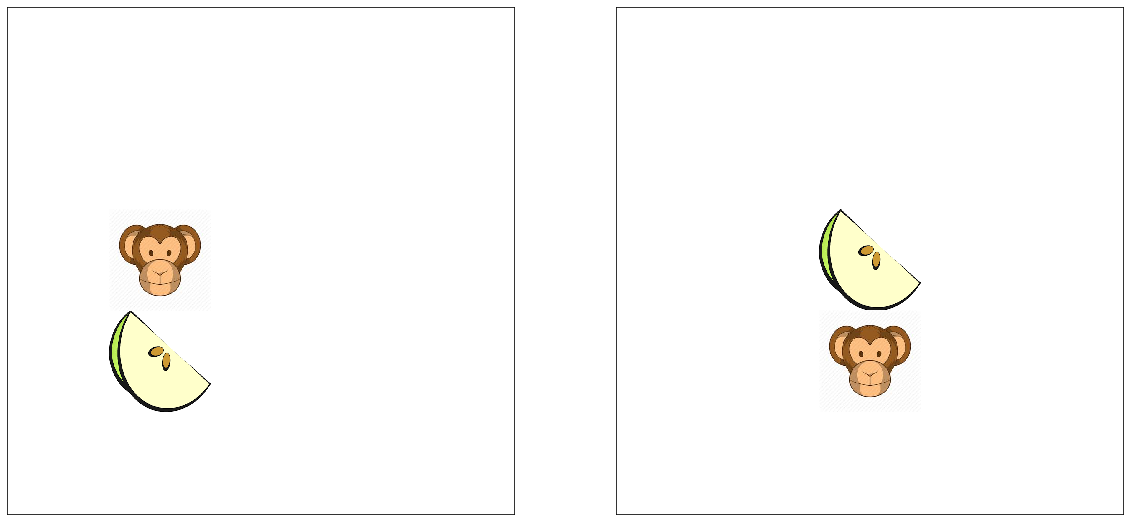

IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
###############################################
## Run the experiment and let the apes learn ##
###############################################
# Set up some parameter variables
show_visualisation = True #False

# Initialise
env = Double_Gridworld(ape_start_pos="random", button_pos=np.array([[2, 4], [2, 4]]),
                 good_food_pos=np.array([[2, 0], [2,0]]), bad_food_pos="random")
Ape0 = Ape(env, 0)
Ape1 = Ape(env, 1)

for i in range(100):
    # Show the state of the experiment
    if show_visualisation:
        env.visualise()
    
    # Move ape 0
    move0 = Ape0.choose_move()
    r0 = env.move_ape(0, move0)
    Ape0.update_Q(move0, r0)
    
    # Move ape 1
    move1 = Ape1.choose_move()
    r1 = env.move_ape(1, move1)
    Ape1.update_Q(move1, r1)

Ape0.save_Q("Initial run")
Ape1.save_Q("Initial run")

In [37]:
a = np.array([2, 2])
b = np.array([1, 1])
print(np.array(a)-np.array(b))

[1 1]


C:\Users\jonba\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\jonba\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\jonba\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\jonba\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


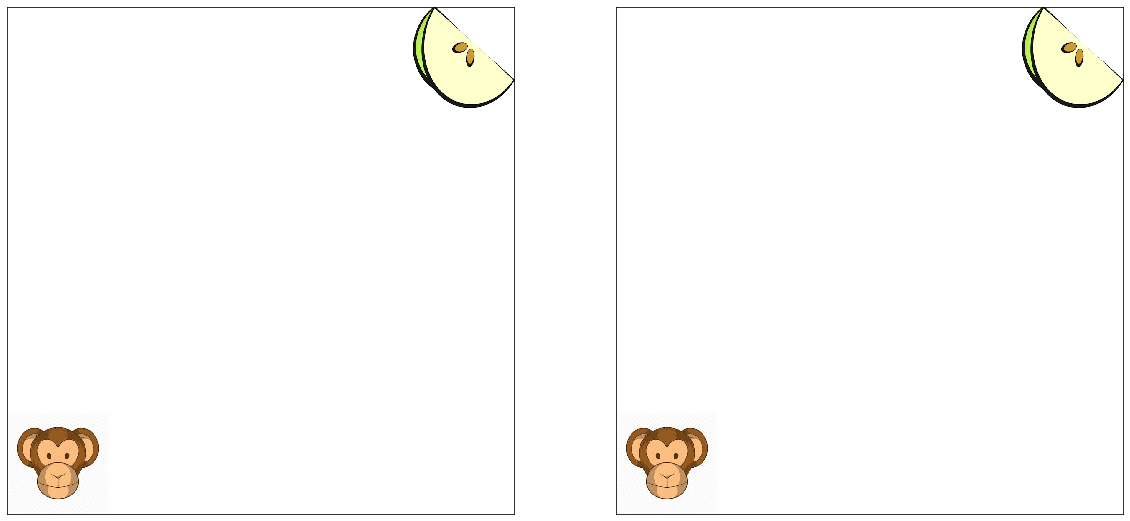

[2, 4, 0, 0, 4, 4, 2, 4] 

[2, 4, 0, 0, 4, 4, 2, 4] 





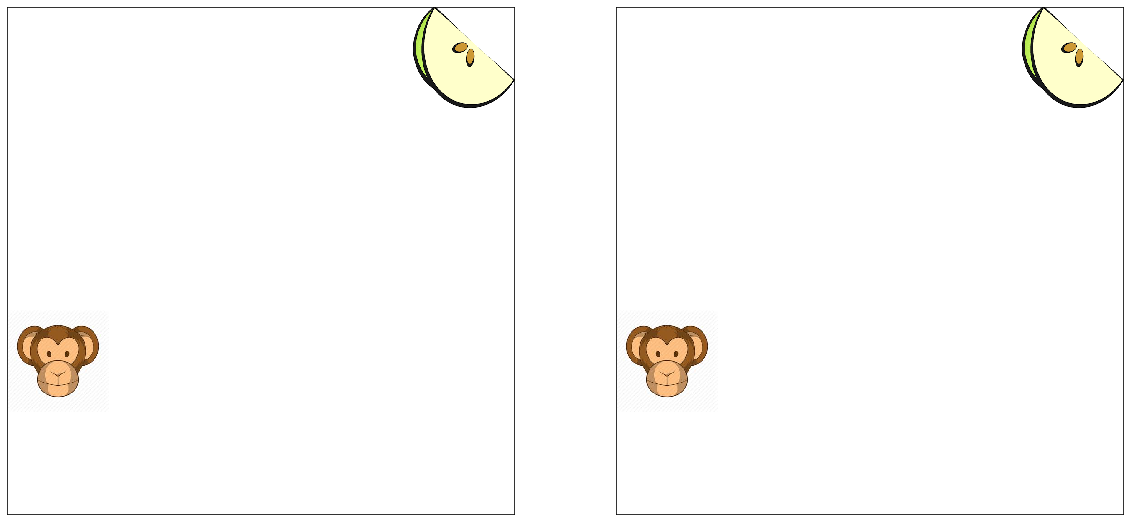

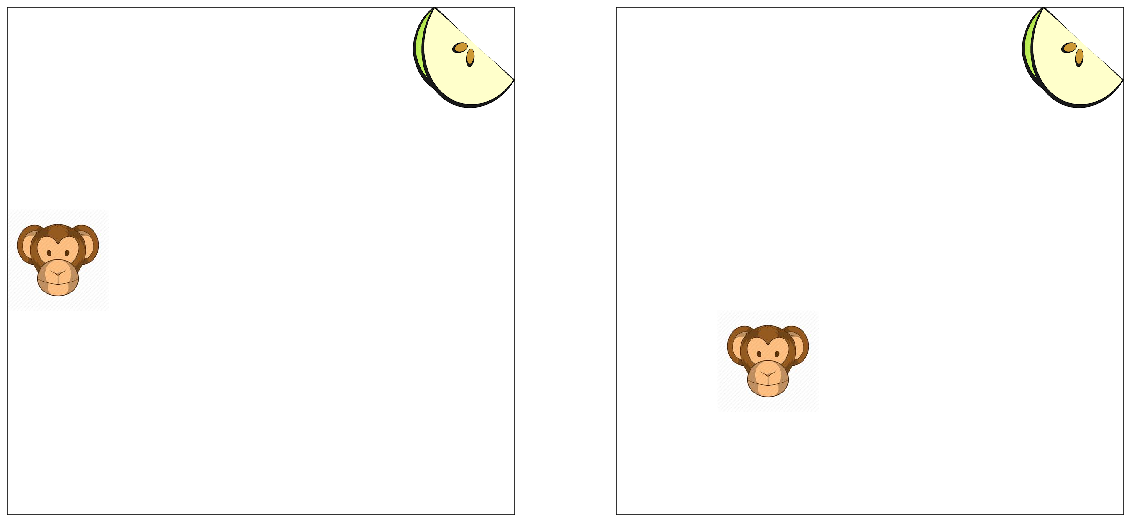

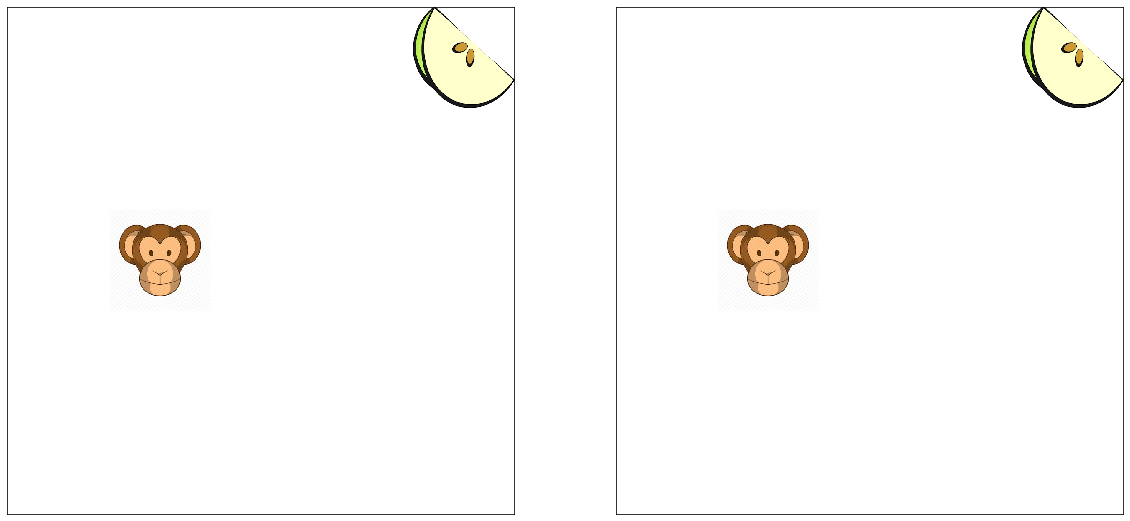

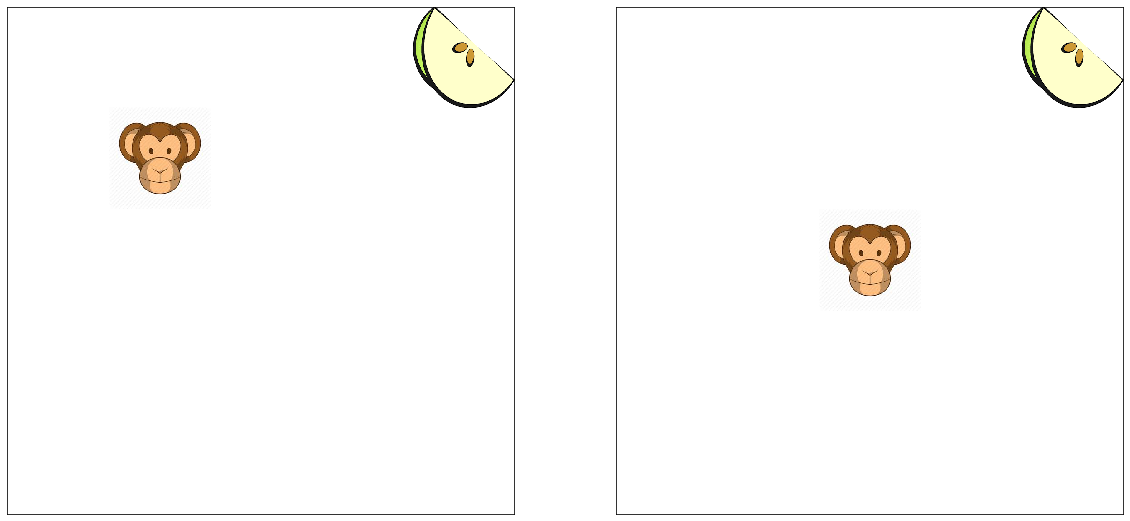

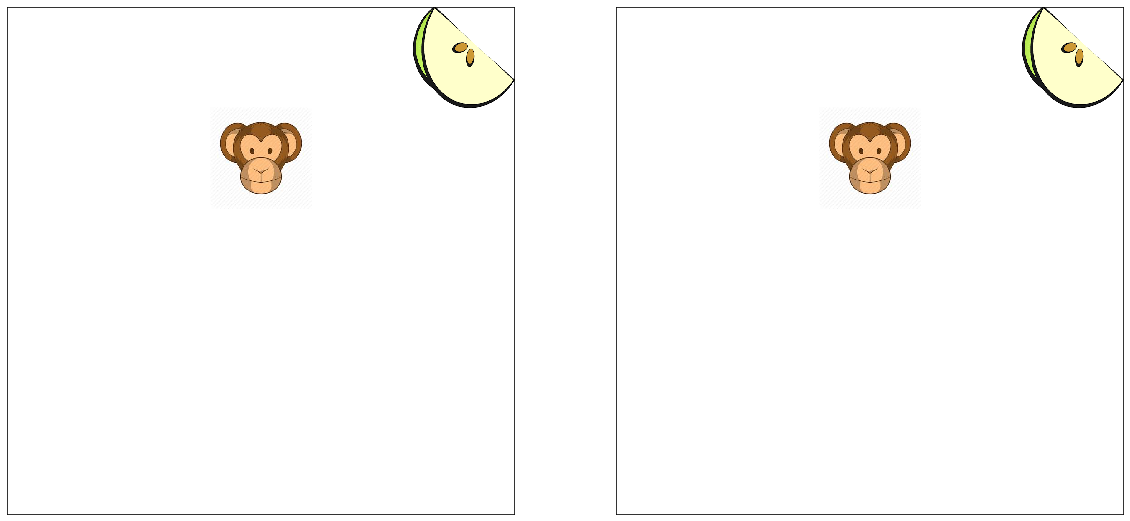

good food dropped
good food dropped


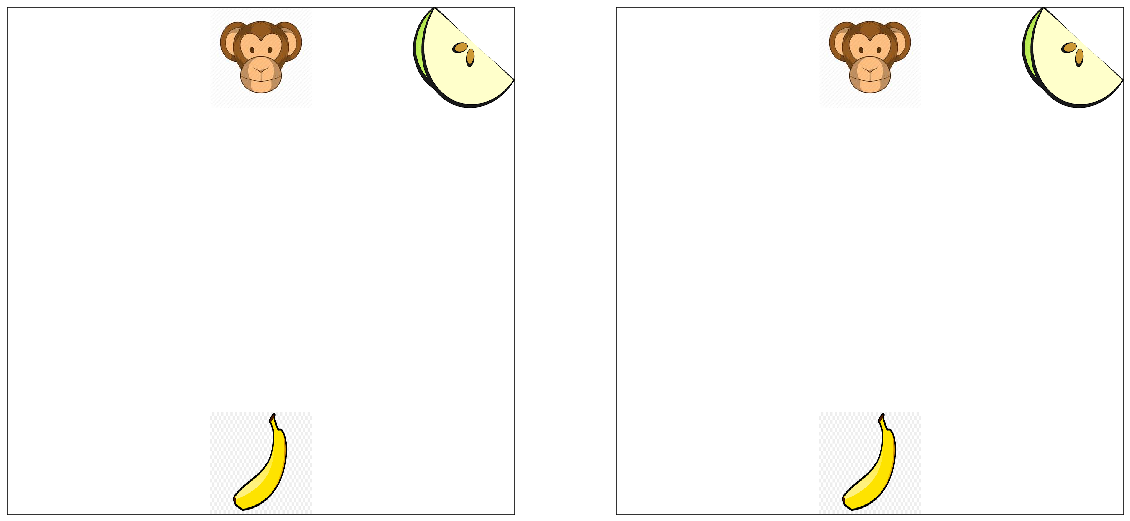

[0, 0, 0, -4, 2, 0, 0, 0] 

[0, 0, 0, -4, 2, 0, 0, 0]


In [34]:
env = Double_Gridworld(ape_start_pos=np.array([[0, 0], [0, 0]]), button_pos=np.array([[2, 4], [2, 4]]),
                 good_food_pos=np.array([[2, 0], [2,0]]), bad_food_pos=np.array([[4, 4], [4, 4]]))
Ape0 = Ape(env, 0)
Ape1 = Ape(env, 1)

env.visualise()
print(Ape0.get_state(), "\n")
print(Ape1.get_state(), "\n\n\n")

env.move_ape(0, "u")
env.move_ape(1, "u")
env.visualise()

env.move_ape(0, "u")
env.move_ape(1, "r")
env.visualise()

env.move_ape(0, "r")
env.move_ape(1, "u")
env.visualise()

env.move_ape(0, "u")
env.move_ape(1, "r")
env.visualise()

env.move_ape(0, "r")
env.move_ape(1, "u")
env.visualise()

env.move_ape(0, "u")
env.move_ape(1, "u")
env.visualise()
print(Ape0.get_state(), "\n")
print(Ape1.get_state())

In [ ]:
# Calculate the number of elements in Q
print(5*(9**8))

In [ ]:
# Calculate the average distance between grid cells
counter = 0
dist_sum = 0
for i in range(5):
    for j in range(5):
        for k in range(5):
            for l in range(5):
                if True: #<- includes distances from cells to themselves #not (i==k and j==l): #<- does not include trivial distances
                    counter += 1
                    dist_sum += np.abs(k-i) + np.abs(l-j)
avg_dist = dist_sum / float(counter)
print(avg_dist)